# Define Packages

In [617]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Data load and check both files

train size :  (370703, 24)
test size :  (92676, 23)


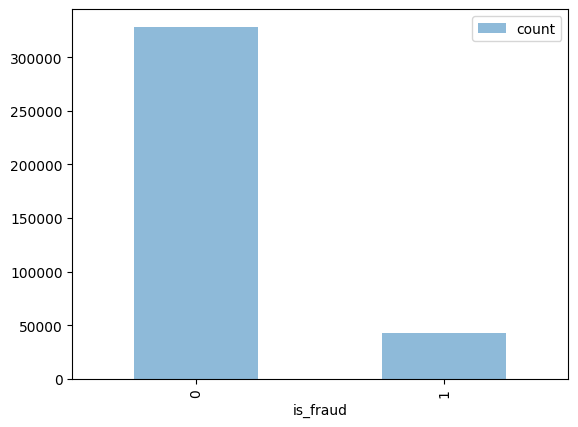

In [618]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

# print the first data to check the data type
print("train size : ", train.shape)  # Check each row data type
print("test size : ", test.shape)

train['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

In [619]:
positive = train['is_fraud'].sum()
negative = len(train) - positive

positive, negative

(42299, 328404)

What Model Should I Use?

# SVM or XGBoost

# Preprocessing

- id : id (Not Important)   (Not important)
- trans_num: The transaction number.                                                (Not Important)
- --
- trans_date: The date of the transaction. [important]
- trans_time: The time of the transaction. [important]
- ---
- unix_time: A UNIX timestamp for the transaction.                                  (Not Important)
- --
- category: The transaction category (e.g., grocery_pos, food_dining). [important]
- amt: The transaction amount.                                                      [important]
- ---
- cc_num: Credit card number associated with the transaction. (Not Important)
- first: First name of the cardholder.
- last: Last name of the cardholder.
- ---
- gender: Gender of the cardholder.  [important]
- ---
- street: Street address of the cardholder.
- city: City of the cardholder.
- state: State of the cardholder.
- zip: ZIP code of the cardholder.
- lat: Latitude of the cardholder’s location.
- long: Longitude of the cardholder’s location.
- city_pop: Population of the cardholder’s city.
- job: Occupation of the cardholder.
- dob: Date of birth of the cardholder.
- merchant: Merchant associated with the transaction.
- merch_lat: Latitude of the merchant’s location.
- merch_long: Longitude of the merchant’s location.
- is_fraud: Target variable (1 = fraudulent, 0 = legitimate).

# AMT analysis - Important

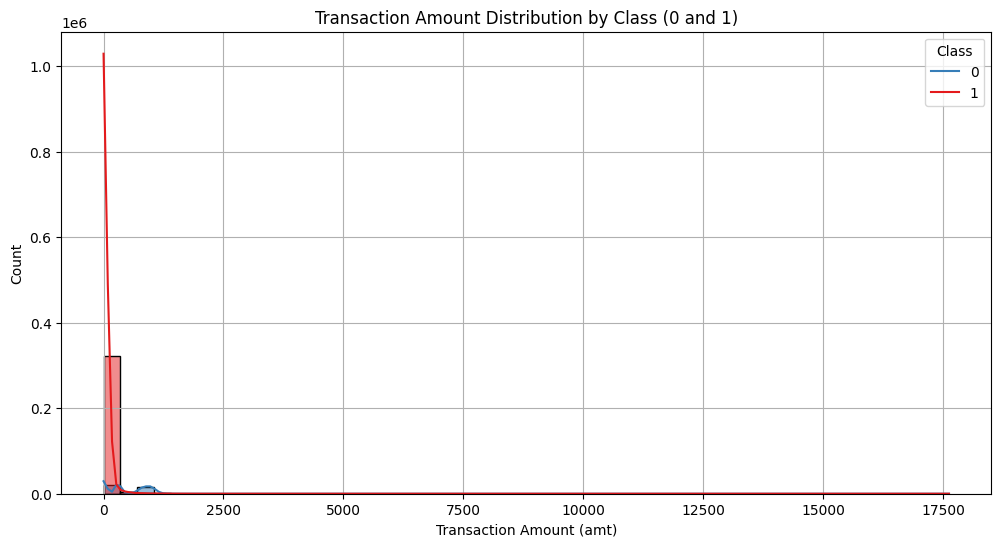

/var/folders/xt/y_17jz6n3p77v5p6cbm1tstr0000gn/T/ipykernel_33997/327411409.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='is_fraud', y='amt', palette='Set2')


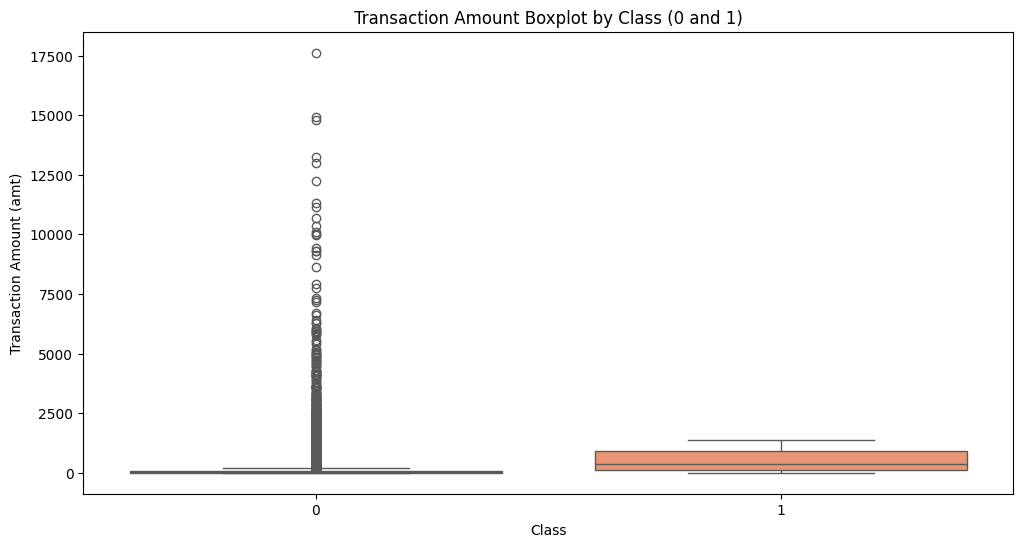

                mean  median         std   count
is_fraud                                        
0          73.978759   47.28  161.774888  328404
1         507.970919  354.36  393.961353   42299


In [620]:
import seaborn as sns

# amt와 target(0/1) 컬럼이 있다고 가정
# 'target' 컬럼이 0/1 값을 포함해야 합니다.

# 분포 시각화: 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='amt', hue='is_fraud', kde=True, bins=50, palette='Set1')
plt.title('Transaction Amount Distribution by Class (0 and 1)')
plt.xlabel('Transaction Amount (amt)')
plt.ylabel('Count')
plt.legend(title='Class', labels=['0', '1'])
plt.grid()
plt.show()

# 분포 시각화: 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='is_fraud', y='amt', palette='Set2')
plt.title('Transaction Amount Boxplot by Class (0 and 1)')
plt.xlabel('Class')
plt.ylabel('Transaction Amount (amt)')
plt.show()

summary = train.groupby('is_fraud')['amt'].agg(['mean', 'median', 'std', 'count'])
print(summary)

# Drop Unnecessary items

In [621]:
# Get rid of unnecessary column
train = train.drop(['id', 'trans_num', 'unix_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip','dob'], axis=1)
test = test.drop(['trans_num', 'unix_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip','dob'], axis=1)

train.columns

Index(['trans_date', 'trans_time', 'category', 'amt', 'gender', 'lat', 'long',
       'city_pop', 'job', 'merchant', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

## Temporal Date
trans_date -> Day of week 

trans_time -> Hour of Day

In [622]:
# Trans_date -> Day of week
train['trans_day'] = pd.to_datetime(train['trans_date']).dt.day_of_week
train['trans_day_sin'] = np.sin(2 * np.pi * train['trans_day'] / 7)
train['trans_day_cos'] = np.cos(2 * np.pi * train['trans_day'] / 7)

test['trans_day'] = pd.to_datetime(test['trans_date']).dt.day_of_week
test['trans_day_sin'] = np.sin(2 * np.pi * test['trans_day'] / 7)
test['trans_day_cos'] = np.cos(2 * np.pi * test['trans_day'] / 7)

# Trans_time -> Hour of Day 
train['trans_hour'] = pd.to_datetime(train['trans_time']).dt.hour
train['trans_hour_sin'] = np.sin(2 * np.pi * train['trans_hour'] / 24)
train['trans_hour_cos'] = np.cos(2 * np.pi * train['trans_hour'] / 24)

test['trans_hour'] = pd.to_datetime(test['trans_time']).dt.hour
test['trans_hour_sin'] = np.sin(2 * np.pi * test['trans_hour'] / 24)
test['trans_hour_cos'] = np.cos(2 * np.pi * test['trans_hour'] / 24)

/var/folders/xt/y_17jz6n3p77v5p6cbm1tstr0000gn/T/ipykernel_33997/313654721.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['trans_hour'] = pd.to_datetime(train['trans_time']).dt.hour
/var/folders/xt/y_17jz6n3p77v5p6cbm1tstr0000gn/T/ipykernel_33997/313654721.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['trans_hour'] = pd.to_datetime(test['trans_time']).dt.hour


# Geographic Features

In [623]:
from geopy.distance import geodesic

# Apply geodesic distance calculation
train['distance'] = train.apply(
    lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1
)

test['distance'] = test.apply(
    lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1
)

# Numerical Columns

In [473]:
upper_limit = train['amt'].quantile(0.99)
train = train[train['amt'] <= upper_limit]
test = test[test['amt'] <= upper_limit]

In [474]:
upper_limit = train['distance'].quantile(0.99)
train = train[train['distance'] <= upper_limit]
test = test[test['distance'] <= upper_limit]


In [624]:
scaler = StandardScaler()
train[['amt', 'city_pop', 'distance']] = scaler.fit_transform(train[['amt', 'city_pop', 'distance']])
test[['amt', 'city_pop', 'distance']] = scaler.transform(test[['amt', 'city_pop', 'distance']])

# Categorical Columns

In [ ]:
categoty, job, gender, merchange

In [625]:
# Convert dab to age
def category_preprocessing(train, test, column):
    train[column] = train[column].str.lower()
    test[column] = test[column].str.lower()

    train[column] = train[column].str.strip()
    test[column] = test[column].str.strip()
    
    le = LabelEncoder()
    train[column] = le.fit_transform(train[column])
    test[column] = test[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

    return train, test

In [626]:
unique_count = train['category'].nunique()
print(f"Number of unique categories: {unique_count}")
unique_values = train['category'].unique()
print(unique_values)

Number of unique categories: 14
['misc_pos' 'grocery_pos' 'entertainment' 'health_fitness' 'grocery_net'
 'shopping_net' 'gas_transport' 'shopping_pos' 'kids_pets' 'misc_net'
 'personal_care' 'travel' 'home' 'food_dining']


In [627]:
train, test = category_preprocessing(train, test, 'category')
train, test = category_preprocessing(train, test, 'job')

train['merchant'] = train['merchant'].str.replace(r'^fraud_', '', regex=True)
test['merchant'] = test['merchant'].str.replace(r'^fraud_', '', regex=True)

train, test = category_preprocessing(train, test, 'merchant')

train = pd.get_dummies(train, columns=['gender'], drop_first=True)
test = pd.get_dummies(test, columns=['gender'], drop_first=True)

In [628]:
fraud_rate = train.groupby('merchant')['is_fraud'].mean()
train['merchant_fraud_rate'] = train['merchant'].map(fraud_rate)
test['merchant_fraud_rate'] = test['merchant'].map(fraud_rate)

# Preprocessing categorical Data

In [629]:
# feature_usages = ['category', 'amt', 'trans_day_sin', 'trans_day_cos', 'trans_hour_sin', 'trans_hour_cos', 'city_pop', 'job', 'merchant', 'distance', 'gender_M', 'merchant_fraud_rate']
feature_usages = ['category', 'amt', 'trans_day_sin', 'trans_day_cos', 'trans_hour_sin', 'trans_hour_cos', 'gender_M', 'merchant_fraud_rate']
X = train[feature_usages]
y = train['is_fraud']
test_x = test[feature_usages]

In [481]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [482]:
num_0 = sum(y == 0 for y in y_train)
num_1 = sum(y == 1 for y in y_train)

print("Total Train : ", len(y_train))
print("Total 1 : ", num_1)
print("Total 0 : ", num_0)

scale_pos_weight = num_0 / num_1
print("Scale pos weight : ", scale_pos_weight)

Total Train :  290660
Total 1 :  31325
Total 0 :  259335
Scale pos weight :  8.278850758180367


### Check Data set

In [369]:
X_train.columns

Index(['category', 'amt', 'trans_day_sin', 'trans_day_cos', 'trans_hour_sin',
       'trans_hour_cos', 'city_pop', 'job', 'merchant', 'distance', 'gender_M',
       'merchant_fraud_rate'],
      dtype='object')

# Random Forrest Classifier

In [416]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',  # 클래스 불균형 해결
    n_jobs=-1
)

In [417]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

In [418]:
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9535884328509192

Confusion Matrix:
[[62706  2886]
 [  555  7994]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     65592
           1       0.73      0.94      0.82      8549

    accuracy                           0.95     74141
   macro avg       0.86      0.95      0.90     74141
weighted avg       0.96      0.95      0.96     74141



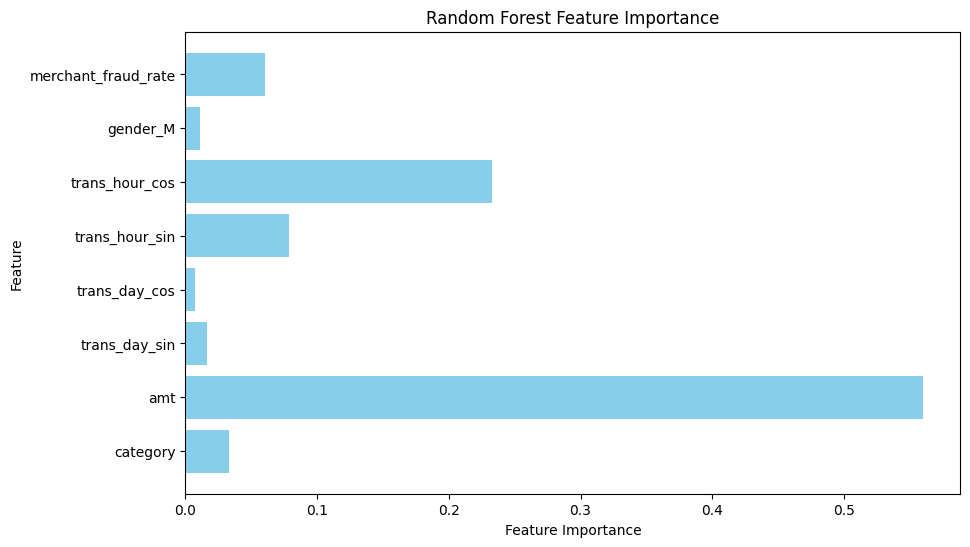

In [419]:
import matplotlib.pyplot as plt

# 피처 중요도
importances = model.feature_importances_
features = X.columns

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

# XGBoost Model

In [630]:
from collections import Counter

# 클래스 비율 계산
class_counts = Counter(y)
scale_pos_weight = class_counts[0] / class_counts[1]

print(scale_pos_weight)

7.763871486323554


In [575]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight = scale_pos_weight,
    use_label_encoder=False,
    n_estimators=100,
    min_child_weight = 1,
    max_depth=7,
    learning_rate=0.2,
    random_state=42
)

In [576]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [577]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [579]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.85
y_pred = (y_pred_proba > threshold).astype(int)

In [580]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     64951
           1       0.91      0.88      0.89      7714

    accuracy                           0.98     72665
   macro avg       0.95      0.93      0.94     72665
weighted avg       0.98      0.98      0.98     72665



# HyperParmeter Tuning

## N_estimator

In [631]:
learningRate = 0.2
booster = 'gbtree'
n_estimators = 500
maxDepth = 10
minChildWeight = 0
gamma = 0.3
subsample = 0.85
colsampleByTree = 0.9
scalePosWeight = scale_pos_weight
earlyStoppingRounds = 100
evalMetric = "logloss"
regAlpha = 1e-05

In [632]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=0, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [608]:
# Make predictions on the test set
y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     64951
           1       0.86      0.90      0.88      7714

    accuracy                           0.97     72665
   macro avg       0.92      0.94      0.93     72665
weighted avg       0.97      0.97      0.97     72665



In [613]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
threshold = 0.7
y_pred = (y_pred_proba > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     64951
           1       0.89      0.88      0.89      7714

    accuracy                           0.98     72665
   macro avg       0.94      0.93      0.94     72665
weighted avg       0.98      0.98      0.98     72665



In [610]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.1)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    print(f"Threshold: {threshold}, F1-Score: {f1}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

Threshold: 0.1, F1-Score: 0.8413211687261809
Threshold: 0.2, F1-Score: 0.8613226212602674
Threshold: 0.30000000000000004, F1-Score: 0.8702702702702703
Threshold: 0.4, F1-Score: 0.8757573864701106
Threshold: 0.5, F1-Score: 0.8794623042292816
Threshold: 0.6, F1-Score: 0.8832422000643294
Threshold: 0.7000000000000001, F1-Score: 0.8851965722509322
Threshold: 0.8, F1-Score: 0.8850536416339042
Best Threshold: 0.7000000000000001, Best F1-Score: 0.8851965722509322


In [605]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.8, 0.9, 0.01)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    print(f"Threshold: {threshold}, F1-Score: {f1}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

Threshold: 0.8, F1-Score: 0.8900314930265442
Threshold: 0.81, F1-Score: 0.8914728682170543
Threshold: 0.8200000000000001, F1-Score: 0.8919304618578101
Threshold: 0.8300000000000001, F1-Score: 0.8919447340980188
Threshold: 0.8400000000000001, F1-Score: 0.8926279952861071
Threshold: 0.8500000000000001, F1-Score: 0.8940959652471533
Threshold: 0.8600000000000001, F1-Score: 0.8938842975206611
Threshold: 0.8700000000000001, F1-Score: 0.894166167764252
Threshold: 0.8800000000000001, F1-Score: 0.893437688139675
Threshold: 0.8900000000000001, F1-Score: 0.8924984835209274
Best Threshold: 0.8700000000000001, Best F1-Score: 0.894166167764252


In [584]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

ParamTest1 = {
    'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2]
}

xgbR1 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch1 = GridSearchCV(estimator = xgbR1,
                        param_grid = ParamTest1,
                        n_jobs=4,
                        cv=5)

gsearch1.fit(X_train,y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.70577536, 0.68109179, 0.6354238 , 0.61983805, 0.56352124]),
  'std_fit_time': array([0.02108765, 0.0210252 , 0.00742346, 0.00565826, 0.11807213]),
  'mean_score_time': array([0.03684721, 0.03371186, 0.03402953, 0.03361897, 0.03133664]),
  'std_score_time': array([0.00279741, 0.00180722, 0.00375061, 0.00130833, 0.00150407]),
  'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1, 0.15, 0.2],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.01},
   {'learning_rate': 0.05},
   {'learning_rate': 0.1},
   {'learning_rate': 0.15},
   {'learning_rate': 0.2}],
  'split0_test_score': array([0.93143191, 0.93772793, 0.94653547, 0.95159293, 0.9567708 ]),
  'split1_test_score': array([0.93150072, 0.93678181, 0.94467763, 0.95150692, 0.95382922]),
  'split2_test_score': array([0.93060621, 0.93578408, 0.94228652, 0.95066401, 0.95432808]),
  'split3_test_score': array([0.93136

## Max Depth & Min Child Weight

In [586]:
ParamTest2 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

xgbR2 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch2 = GridSearchCV(estimator = xgbR2,
                        param_grid = ParamTest2,
                        n_jobs=4,
                        cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.61177859, 0.480936  , 0.51253791, 0.61076999, 0.66022553,
         0.68501587, 0.7971982 , 0.84724073, 0.78112264, 0.98749528,
         0.96456809, 0.92436881]),
  'std_fit_time': array([0.06616396, 0.00453244, 0.0160295 , 0.01538735, 0.02541611,
         0.01932123, 0.0220838 , 0.04821633, 0.01410756, 0.0096011 ,
         0.01245506, 0.02659581]),
  'mean_score_time': array([0.0262537 , 0.024229  , 0.02645521, 0.03403454, 0.03606806,
         0.04091277, 0.04517779, 0.04646392, 0.04884353, 0.06768627,
         0.06727471, 0.06595068]),
  'std_score_time': array([0.00219916, 0.00107235, 0.00383823, 0.00175277, 0.00361596,
         0.00731509, 0.00127863, 0.00075981, 0.0057323 , 0.00534264,
         0.00369284, 0.00212251]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

In [588]:
ParamTest2 = {
    'max_depth': [8, 9, 10],
    'min_child_weight': [0, 1, 2]
}

xgbR2 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch2 = GridSearchCV(estimator = xgbR2,
                        param_grid = ParamTest2,
                        n_jobs=4,
                        cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.97493649, 0.88080401, 0.87793255, 1.01856799, 0.97631731,
         1.0007205 , 1.19130874, 1.07614737, 0.98801322]),
  'std_fit_time': array([0.05013511, 0.00875718, 0.01220555, 0.01828746, 0.01162739,
         0.01802509, 0.01135068, 0.01762156, 0.2092316 ]),
  'mean_score_time': array([0.06987686, 0.0666492 , 0.06314201, 0.07339382, 0.07225351,
         0.07052126, 0.07615027, 0.08004508, 0.08268399]),
  'std_score_time': array([0.00432489, 0.00450575, 0.0046262 , 0.00450848, 0.0053846 ,
         0.00393094, 0.00128969, 0.00075042, 0.01179259]),
  'param_max_depth': masked_array(data=[8, 8, 8, 9, 9, 9, 10, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[0, 1, 2, 0, 1, 2, 0, 1, 2],
               mask=[False, False, False, False, False, False, False, False,
                     False],
      

### Parameter Test 3 - GAMMA

In [590]:
ParamTest3 = {
 'gamma': [i/10.0 for i in range(0,5)]
}

xgbR3 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch3 = GridSearchCV(estimator = xgbR3,
                        param_grid = ParamTest3,
                        n_jobs=4,
                        cv=5)

gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([1.26394362, 1.20216184, 1.27858729, 1.19947448, 1.01802359]),
  'std_fit_time': array([0.03911717, 0.02545139, 0.07464506, 0.07208622, 0.24582962]),
  'mean_score_time': array([0.1036376 , 0.09008422, 0.09169979, 0.08495922, 0.09520311]),
  'std_score_time': array([0.01007815, 0.00717146, 0.00475311, 0.00576432, 0.01246739]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.97030895, 0.97042937, 0.97022294, 0.97097984, 0.97006812]),
  'split1_test_score': array([0.96960366, 0.96962086, 0.96893277, 0.96974128, 0.96867474]),
  'split2_test_score': array([0.97039496, 0.97082502, 0.97087663, 0.97173674, 0.97110025]),
  'split3_test_score': array([0.96994771, 0.96972408, 0.96996491, 0.97011973, 0.97042937]),

### Parameter Test 4 - Subsample & Colsample By Tree

---

In [592]:
ParamTest4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgbR4 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch4 = GridSearchCV(estimator = xgbR4,
                        param_grid = ParamTest4,
                        n_jobs=4,
                        cv=5)

gsearch4.fit(X_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([1.18417449, 1.13492618, 1.16346126, 1.20893459, 1.19444542,
         1.15514131, 1.1423234 , 1.20147362, 1.22488861, 1.18956175,
         1.24145322, 1.20553069, 1.21646156, 1.20996199, 1.23714514,
         1.15383239]),
  'std_fit_time': array([0.03475144, 0.02551574, 0.04864209, 0.04109911, 0.0081652 ,
         0.01995497, 0.00925516, 0.05960511, 0.05020722, 0.02869048,
         0.01783844, 0.02941018, 0.02241965, 0.07078084, 0.05925114,
         0.02365811]),
  'mean_score_time': array([0.10333414, 0.09655018, 0.09359937, 0.09618564, 0.08900943,
         0.0884871 , 0.09217701, 0.11204419, 0.08746166, 0.1041934 ,
         0.11155152, 0.09870672, 0.08827786, 0.09910369, 0.08007479,
         0.07577448]),
  'std_score_time': array([0.01148543, 0.00918665, 0.00285989, 0.01007219, 0.00348562,
         0.00460281, 0.00877837, 0.00803318, 0.0073614 , 0.00919232,
         0.0111335 , 0.01227957, 0.00775474, 0.02385202, 0.00353271,
         0.00314647]),
  'param_c

In [594]:
ParamTest4 = {
 'subsample':[i/100.0 for i in range(75,95,5)],
 'colsample_bytree':[i/100.0 for i in range(75,95,5)]
}

xgbR4 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch4 = GridSearchCV(estimator = xgbR4,
                        param_grid = ParamTest4,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5)

gsearch4.fit(X_train, y_train)

gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([1.25440311, 1.21863241, 1.19003143, 1.19391336, 1.17894554,
         1.19636202, 1.32314014, 1.20328817, 1.23198328, 1.21626701,
         1.2368278 , 1.16995678, 1.1901876 , 1.22848077, 1.15491509,
         1.24911962]),
  'std_fit_time': array([0.02700352, 0.02623947, 0.01755735, 0.0192673 , 0.02453305,
         0.03702858, 0.14621698, 0.12070103, 0.01313552, 0.02408561,
         0.03654414, 0.06270236, 0.01533328, 0.00942821, 0.02212794,
         0.05884747]),
  'mean_score_time': array([0.09142938, 0.079917  , 0.10681386, 0.08149843, 0.08587379,
         0.09509673, 0.10015783, 0.08871274, 0.08383431, 0.08576627,
         0.09125195, 0.0802434 , 0.07990894, 0.08054066, 0.08548884,
         0.09279871]),
  'std_score_time': array([0.01081608, 0.00557939, 0.02045868, 0.00480767, 0.01469381,
         0.01224582, 0.01116968, 0.00886933, 0.00801816, 0.00626786,
         0.00614711, 0.00427151, 0.00537613, 0.0060037 , 0.00720399,
         0.00202898]),
  'param_c

## Step 5 Tuning regularization parameters

In [596]:
ParamTest5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgbR5 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch5 = GridSearchCV(estimator = xgbR5,
                        param_grid = ParamTest5,
                        n_jobs=4,
                        cv=5)

gsearch5.fit(X_train, y_train)

gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([1.16971827, 1.16727018, 1.14761066, 1.22724867, 0.70206037]),
  'std_fit_time': array([0.01745931, 0.03925981, 0.01435741, 0.06625201, 0.15368493]),
  'mean_score_time': array([0.1025003 , 0.09663281, 0.09661207, 0.10031033, 0.09861712]),
  'std_score_time': array([0.00854276, 0.00423466, 0.00760316, 0.00286989, 0.00804633]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.97091103, 0.97170233, 0.97094543, 0.97075621, 0.95897268]),
  'split1_test_score': array([0.9698789 , 0.96998211, 0.96951765, 0.96970687, 0.95711484]),
  'split2_test_score': array([0.97139269, 0.97118627, 0.97177114, 0.97082502, 0.95487855]),
  'split3_test_score': array([0.97115186, 0.97073901, 0.97034336,

In [598]:
ParamTest5 = {
 'n_estimators':[100, 200, 300, 400, 500]
}

xgbR5 = XGBClassifier(
    eval_metric="logloss",
    learning_rate = learningRate,
    use_label_encoder=False,
    n_estimators = n_estimators,
    max_depth = maxDepth,
    min_child_weight= minChildWeight,
    gamma = gamma,
    subsample = subsample,
    colsample_bytree = colsampleByTree,
    scale_pos_weight = scalePosWeight,
    seed=42)

gsearch5 = GridSearchCV(estimator = xgbR5,
                        param_grid = ParamTest5,
                        n_jobs=4,
                        cv=5)

gsearch5.fit(X_train, y_train)

gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([1.19975529, 2.20727773, 3.06525064, 3.68819542, 3.90079269]),
  'std_fit_time': array([0.00491494, 0.01433692, 0.04797401, 0.04761221, 0.58734414]),
  'mean_score_time': array([0.09791222, 0.15116129, 0.1962966 , 0.24168763, 0.28384037]),
  'std_score_time': array([0.01303571, 0.01498091, 0.00865698, 0.00337743, 0.01561068]),
  'param_n_estimators': masked_array(data=[100, 200, 300, 400, 500],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 100},
   {'n_estimators': 200},
   {'n_estimators': 300},
   {'n_estimators': 400},
   {'n_estimators': 500}],
  'split0_test_score': array([0.97091103, 0.97352577, 0.97369779, 0.97399023, 0.97404184]),
  'split1_test_score': array([0.9698789 , 0.97330214, 0.9737666 , 0.97402463, 0.97407624]),
  'split2_test_score': array([0.97139269, 0.97404184, 0.97521159, 0.97500516, 0.97509117]),
  'split3_test_score': array([0.97115186, 0.97435

In [346]:
from imblearn.over_sampling import SMOTE

smote_tomek = SMOTE(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

In [444]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [568]:
# XGBoost 모델 학습
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

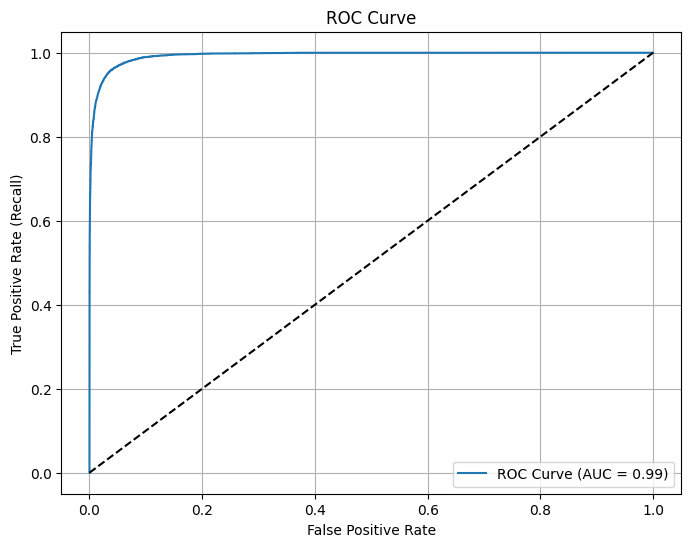

Optimal Threshold: 0.5546690225601196


In [447]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 확률값 예측
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 가장 적절한 threshold 출력 (중간 지점 예시)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")


In [406]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.1)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    print(f"Threshold: {threshold}, F1-Score: {f1}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")


Threshold: 0.1, F1-Score: 0.6922668843093246
Threshold: 0.2, F1-Score: 0.7561424785518573
Threshold: 0.30000000000000004, F1-Score: 0.7971560815002148
Threshold: 0.4, F1-Score: 0.8297829581993569
Threshold: 0.5, F1-Score: 0.8564678706425871
Threshold: 0.6, F1-Score: 0.8761177753544166
Threshold: 0.7000000000000001, F1-Score: 0.8873239436619719
Threshold: 0.8, F1-Score: 0.895171202809482
Best Threshold: 0.8, Best F1-Score: 0.895171202809482


# Hyper Parameter Tuning

In [341]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

eval_set = [(X_train, y_train), (X_val, y_val)]

model = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=7.787,  # 클래스 불균형 처리
    use_label_encoder=False,
    n_estimators=100,
    max_depth=7,
    learning_rate=0.2,
    random_state=42
)

# 모델 학습
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    eval_metric=["logloss", "auc"],  # 로스와 AUC를 모니터링
    early_stopping_rounds=10,  # 10번 연속 성능 향상이 없으면 학습 종료
    verbose=True
)

[0]	validation_0-logloss:0.54928	validation_0-auc:0.98223	validation_1-logloss:0.54885	validation_1-auc:0.98185
[1]	validation_0-logloss:0.45248	validation_0-auc:0.98322	validation_1-logloss:0.45183	validation_1-auc:0.98279
[2]	validation_0-logloss:0.38213	validation_0-auc:0.98448	validation_1-logloss:0.38154	validation_1-auc:0.98374


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.33054	validation_0-auc:0.98484	validation_1-logloss:0.32995	validation_1-auc:0.98412
[4]	validation_0-logloss:0.29203	validation_0-auc:0.98513	validation_1-logloss:0.29119	validation_1-auc:0.98456
[5]	validation_0-logloss:0.26267	validation_0-auc:0.98538	validation_1-logloss:0.26169	validation_1-auc:0.98480
[6]	validation_0-logloss:0.23910	validation_0-auc:0.98579	validation_1-logloss:0.23824	validation_1-auc:0.98526
[7]	validation_0-logloss:0.22065	validation_0-auc:0.98623	validation_1-logloss:0.21978	validation_1-auc:0.98559
[8]	validation_0-logloss:0.20642	validation_0-auc:0.98656	validation_1-logloss:0.20550	validation_1-auc:0.98593
[9]	validation_0-logloss:0.19423	validation_0-auc:0.98698	validation_1-logloss:0.19344	validation_1-auc:0.98634
[10]	validation_0-logloss:0.18468	validation_0-auc:0.98717	validation_1-logloss:0.18393	validation_1-auc:0.98647
[11]	validation_0-logloss:0.17691	validation_0-auc:0.98739	validation_1-logloss:0.17628	validation_1-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Evaluation results:
{'validation_0': OrderedDict({'logloss': [0.5492793609984139, 0.4524772770919872, 0.38212734995867853, 0.33053946383716215, 0.292028308597144, 0.2626720739997784, 0.23909693698048506, 0.22065298758011187, 0.20642129106101098, 0.1942318395719674, 0.18467650551090578, 0.17690627314868074, 0.17013180148101756, 0.16466243497270205, 0.15971569149377468, 0.15571914465443734, 0.15143886841296503, 0.1474357980707232, 0.144593840291136, 0.14220923246087486, 0.1396340024207076, 0.13692679794334786, 0.13481697371485182, 0.1332627232273613, 0.13152632590567626, 0.1276400624247083, 0.12523508120302926, 0.12387509473764971, 0.12246188955813431, 0.1202393377818946, 0.11917813160164059, 0.11777876654165735, 0.11594899368451089, 0.112689069407006, 0.11048329146809467, 0.11001624347015591, 0.1073706947358904, 0.10709001832308429, 0.10631660384560815, 0.10597772898368295, 0.10523872965204753, 0.10319122262712867, 0.1027939580732292, 0.10197051985830634, 0.1017738388623928, 0.101341489

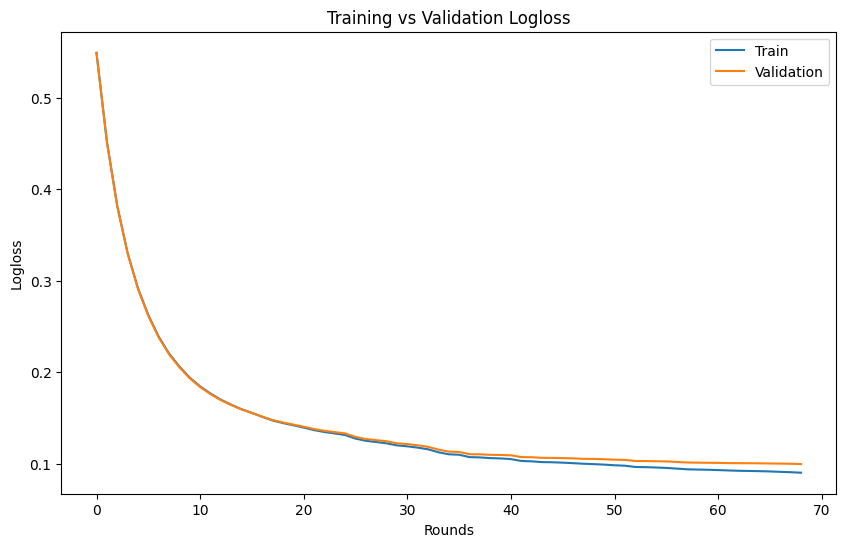

In [342]:
results = model.evals_result()
print("Evaluation results:")
print(results)

# 시각화
import matplotlib.pyplot as plt

# 검증 데이터의 로그 손실 확인
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='Train')
plt.plot(results['validation_1']['logloss'], label='Validation')
plt.xlabel('Rounds')
plt.ylabel('Logloss')
plt.title('Training vs Validation Logloss')
plt.legend()
plt.show()

In [569]:
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     64951
           1       1.00      0.03      0.05      7714

    accuracy                           0.90     72665
   macro avg       0.95      0.51      0.50     72665
weighted avg       0.91      0.90      0.85     72665



In [291]:
scale_pos_weights = [5, 7.8, 10]
for spw in scale_pos_weights:
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=spw,
        use_label_encoder=False,
        n_estimators=100,
        min_child_weight=1,
        max_depth=7,
        learning_rate=0.2,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Scale_Pos_Weight: {spw}")
    print(classification_report(y_test, y_pred))

Scale_Pos_Weight: 5
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     65592
           1       0.82      0.94      0.88      8549

    accuracy                           0.97     74141
   macro avg       0.91      0.96      0.93     74141
weighted avg       0.97      0.97      0.97     74141

Scale_Pos_Weight: 7.8
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     65592
           1       0.78      0.95      0.86      8549

    accuracy                           0.96     74141
   macro avg       0.89      0.96      0.92     74141
weighted avg       0.97      0.96      0.97     74141

Scale_Pos_Weight: 10
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     65592
           1       0.76      0.96      0.85      8549

    accuracy                           0.96     74141
   macro avg       0.88      0.96      0.91     74141
weighted av

In [272]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [0.7, 0.75, 0.65]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric="logloss"),
    param_grid=param_grid,
    scoring='f1',
    cv=3
)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'scale_pos_weight': 0.75}


In [487]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [570]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.85
y_pred = (y_pred_proba > threshold).astype(int)

In [572]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [573]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     64951
           1       1.00      0.03      0.05      7714

    accuracy                           0.90     72665
   macro avg       0.95      0.51      0.50     72665
weighted avg       0.91      0.90      0.85     72665



In [633]:
test_id = test["id"]
test_id.head()

0     52329
1     92215
2    107070
3    117508
4    525132
Name: id, dtype: int64

In [634]:
y_test_proba = xgb.predict_proba(test_x)[:, 1]
threshold = 0.7
y_pred = (y_test_proba > threshold).astype(int)

In [635]:
print(y_pred)
result = pd.DataFrame({
    "id" : test_id,
    "is_fraud" : y_pred
})

result.head()

result.to_csv("submission6.csv", index=False)

[0 0 0 ... 0 0 1]


# Train the SVM Model

In [327]:
svm_model = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

# Make Prediction

In [328]:
# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model

In [330]:
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[65518    74]
 [ 8548     1]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     65592
           1       0.01      0.00      0.00      8549

    accuracy                           0.88     74141
   macro avg       0.45      0.50      0.47     74141
weighted avg       0.78      0.88      0.83     74141



In [73]:
file1 = pd.read_csv("submission_2.csv")
file2 = pd.read_csv("submission.csv")

if file1.equals(file2):
    print("identical")
else:
    print("different")

different


In [636]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

y_nn_train = y_train.values

# Neural Network 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # 과적합 방지
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 Sigmoid 출력층
])

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # 이진 분류
    metrics=['accuracy']
)

# 클래스 가중치 설정 (클래스 불균형 처리)
from collections import Counter
class_counts = Counter(y_nn_train)
class_weights = {0: 1, 1: class_counts[0] / class_counts[1]}

# 모델 학습
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_nn_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    # callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 360us/step - accuracy: 0.8482 - loss: 0.6387 - val_accuracy: 0.8922 - val_loss: 0.2753
Epoch 2/50
7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 351us/step - accuracy: 0.9014 - loss: 0.4715 - val_accuracy: 0.9190 - val_loss: 0.2043
Epoch 3/50
7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 360us/step - accuracy: 0.9105 - loss: 0.4212 - val_accuracy: 0.9218 - val_loss: 0.1963
Epoch 4/50
7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 350us/step - accuracy: 0.9165 - loss: 0.4019 - val_accuracy: 0.9323 - val_loss: 0.1746
Epoch 5/50
7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 357us/step - accuracy: 0.9218 - loss: 0.3794 - val_accuracy: 0.9323 - val_loss: 0.1763
Epoch 6/50
7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 364us/step - accuracy: 0.9224 - loss: 0.3773 - val_accuracy: 0.9305 - val_loss: 0.1732
Epoch 7/50
7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 348us/step - accuracy: 0.9231 - loss: 0.3730 - val_accuracy: 0.9281 - val_loss: 0.1892
Epoch 8/50
7267/7267 ━━━━━━━━━━━━━━━━━━━━ 3s 348us/step - accuracy: 0.9242 - loss: 0.36

In [653]:
# 예측
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# 성능 평가
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


2271/2271 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step
Confusion Matrix:
[[61764  3187]
 [  521  7193]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     64951
           1       0.69      0.93      0.80      7714

    accuracy                           0.95     72665
   macro avg       0.84      0.94      0.88     72665
weighted avg       0.96      0.95      0.95     72665



In [658]:
test_id = test["id"].values

In [670]:
y_pred_proba = model.predict(submission_x)
y_pred = (y_pred_proba > 0.5).astype(int)

2897/2897 ━━━━━━━━━━━━━━━━━━━━ 1s 199us/step


In [ ]:
y_test_proba = xgb.predict_proba(test_x)[:, 1]
threshold = 0.7
y_pred = (y_test_proba > threshold).astype(int)

In [671]:
y_pred = y_pred.flatten()
print(len(y_pred))
print(len(test_id))
result = pd.DataFrame({
    "id" : test_id,
    "is_fraud" : y_pred
})

result.head()

result.to_csv("submission7.csv", index=False)

92676
92676
